In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
import cv2
from PIL import Image
import clip
from tqdm import tqdm
import argparse
from pathlib import Path

In [2]:
def extract_frame_at_time(video_path, timestamp, output_path=None):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
        output_path (str, optional): Path to save the frame image
    
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    
    # Set position to the specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert to PIL Image
    pil_image = Image.fromarray(frame_rgb)
    
    if output_path:
        pil_image.save(output_path)
    
    return pil_image

In [5]:
video_path = "spider-man-far-from-home.mp4"
timestamp = 725.0

In [5]:
cap = cv2.VideoCapture('spider-man-far-from-home.mp4')
duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
print(duration)
cap.release()

7763.7637637637645


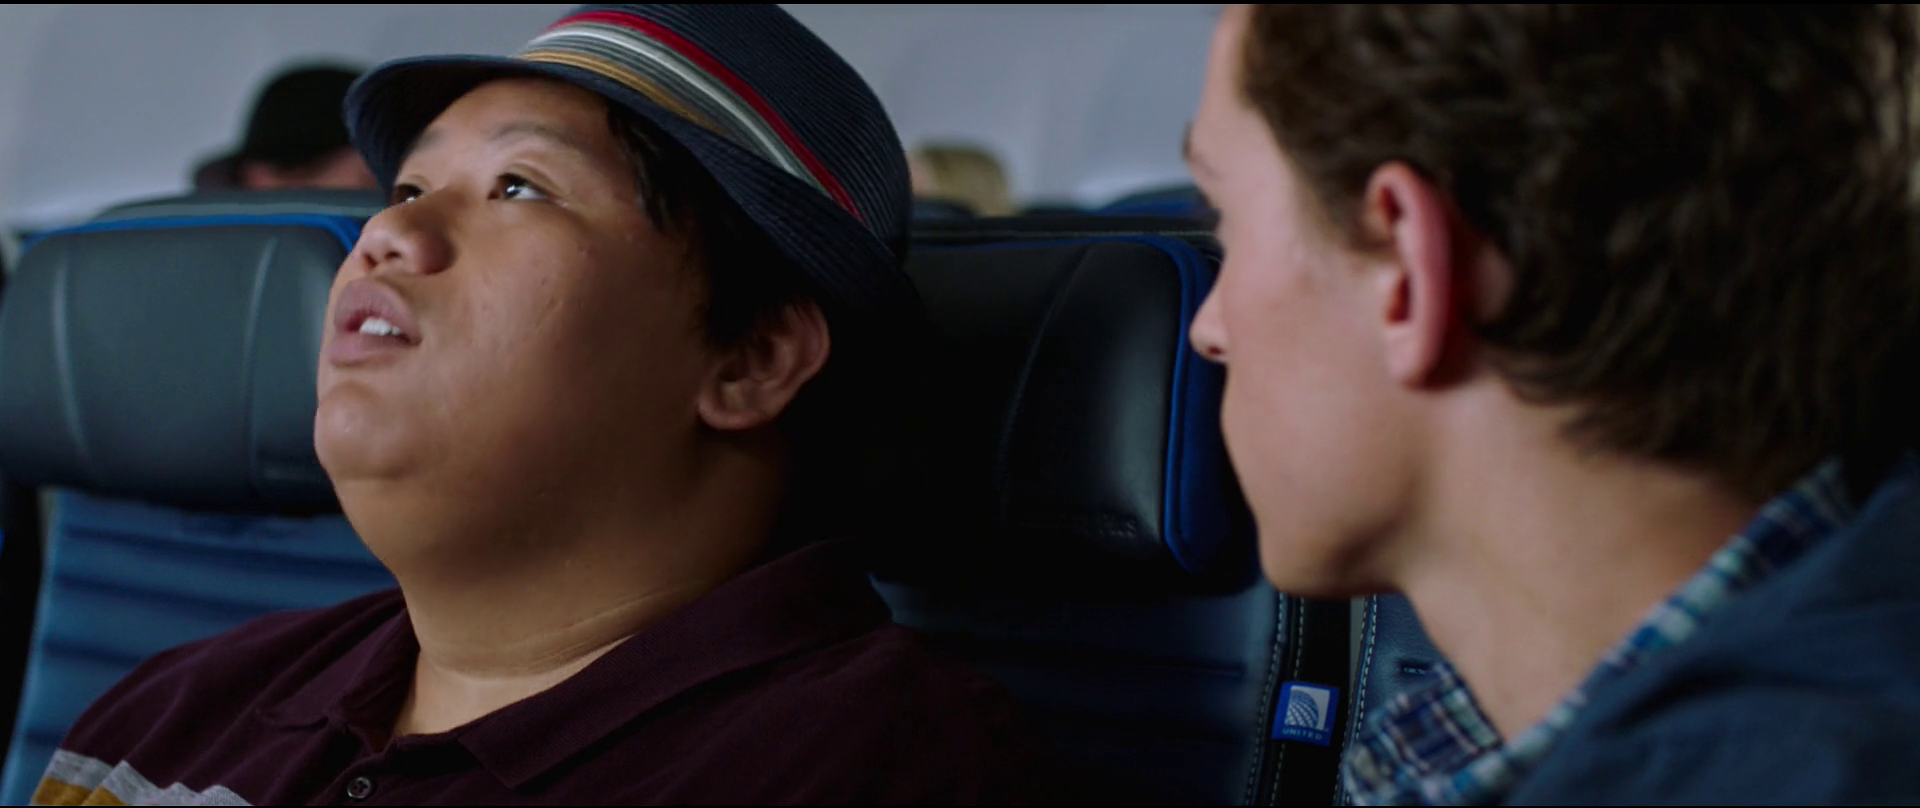

In [6]:
pil_image = extract_frame_at_time(video_path, timestamp, output_path=None)
pil_image

In [7]:
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE


def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

obtain_neural_data_index(10, 1, np.array([725]))

,type,movie_time,start_time,end_time,index,diff
0,beginning,0.000000,0.000000,0.015000,217171,656
1,trigger,0.050000,0.320312,0.335313,217827,340
2,trigger,0.216016,0.486328,0.501328,218167,171
3,trigger,0.299512,0.569824,0.584824,218338,274
4,trigger,0.433301,0.703613,0.718613,218612,174


array([3243892])

In [8]:
def get_clip_features(model, preprocess, image, device):
    """
    Extract CLIP features from an image.
    
    Args:
        model: CLIP model
        preprocess: CLIP preprocessing function
        image: PIL Image
        device: torch device
    
    Returns:
        torch.Tensor: CLIP features
    """
    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    # Extract features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu()

In [9]:
# import clip
print("Loading CLIP model...")
device = torch.device('cuda')
model, preprocess = clip.load("ViT-B/32", device=device)

Loading CLIP model...


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 177MiB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx